In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Install dependencies quietly
!pip install ucimlrepo xgboost optuna joblib matplotlib -q librosa numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.4 MB/s eta 0:00:00


[I 2025-04-07 07:48:21,144] A new study created in memory with name: no-name-b8524ce1-a747-440f-a5ad-448317b8070f
[I 2025-04-07 07:48:24,469] Trial 0 finished with value: 0.09651472866535186 and parameters: {'n_estimators': 293, 'learning_rate': 0.08849710139295607, 'max_depth': 3, 'gamma': 0.8242816496192108, 'reg_alpha': 0.8083437854746456, 'reg_lambda': 0.8441976712882103, 'subsample': 0.6553145748391594}. Best is trial 0 with value: 0.09651472866535186.
[I 2025-04-07 07:48:25,794] Trial 1 finished with value: 0.11495009362697602 and parameters: {'n_estimators': 122, 'learning_rate': 0.07395042914949028, 'max_depth': 3, 'gamma': 0.998860068443186, 'reg_alpha': 0.9079653105111167, 'reg_lambda': 0.8026795369668601, 'subsample': 0.7378894697980931}. Best is trial 0 with value: 0.09651472866535186.
[I 2025-04-07 07:48:27,865] Trial 2 finished with value: 0.09637670516967774 and parameters: {'n_estimators': 241, 'learning_rate': 0.05628194604675871, 'max_depth': 3, 'gamma': 0.80693064005

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 14
[LightGBM] [Info] Start training from score 21.646407
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 14
[LightGBM] [Info] Start training from score 29.565597

Model Comparison:
XGBoost Test MAE: 0.24598200619220734
LightGBM Test MAE: 0.13983859679374333


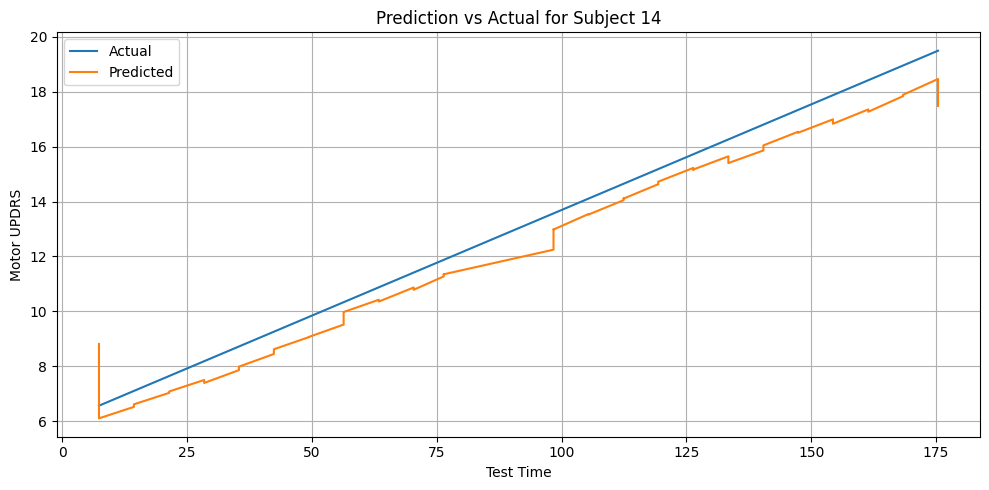


Model saved to: /content/drive/My Drive/parkinsons_model_final.pkl


In [15]:


# Import libraries
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import joblib
from google.colab import drive

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
def load_data():
    parkinsons = fetch_ucirepo(id=189)
    df = pd.concat([
        parkinsons.data.ids,
        parkinsons.data.features,
        parkinsons.data.targets
    ], axis=1)
    return df.sort_values(['subject#', 'test_time']).reset_index(drop=True)

# Enhanced feature engineering with patient baselines
def create_features(df, train_stats=None):
    df = df.copy()

    if train_stats is None:
        train_stats = {
            'mean_motor': df['motor_UPDRS'].mean(),
            'mean_total': df['total_UPDRS'].mean()
        }

    # Patient baseline features
    df = df.assign(
        baseline_motor = df.groupby('subject#')['motor_UPDRS'].transform('first'),
        baseline_total = df.groupby('subject#')['total_UPDRS'].transform('first'),
        previous_motor_UPDRS = df.groupby('subject#')['motor_UPDRS'].shift(1),
        previous_total_UPDRS = df.groupby('subject#')['total_UPDRS'].shift(1),
        months_since_first_test = df.groupby('subject#')['test_time'].transform(lambda x: x - x.min())
    ).fillna({
        'previous_motor_UPDRS': train_stats['mean_motor'],
        'previous_total_UPDRS': train_stats['mean_total']
    })

    # Enhanced clinical features
    return df.assign(
        motor_diff = df['motor_UPDRS'] - df['previous_motor_UPDRS'],
        total_diff = df['total_UPDRS'] - df['previous_total_UPDRS'],
        progress_rate = (df['motor_UPDRS'] - df['baseline_motor']) / (df['months_since_first_test'] + 1e-6),
        NHR_age = df['NHR'] * df['age'],
        Shimmer_trend = df.groupby('subject#')['Shimmer'].transform(
            lambda x: x.rolling(3, min_periods=1).mean()
        )
    ), train_stats

# Main analysis pipeline
def main():
    # Load and split data
    data = load_data()
    train_subjects, test_subjects = train_test_split(
        data['subject#'].unique(),
        test_size=0.2,
        random_state=42
    )

    train_data = data[data['subject#'].isin(train_subjects)].copy()
    test_data = data[data['subject#'].isin(test_subjects)].copy()

    # Feature engineering
    train_data, train_stats = create_features(train_data)
    test_data, _ = create_features(test_data, train_stats)

    # Optimized feature set (removed PPE_trend)
    feature_cols = [
        'baseline_motor', 'previous_motor_UPDRS', 'previous_total_UPDRS',
        'motor_diff', 'total_diff', 'progress_rate', 'months_since_first_test',
        'age', 'NHR', 'HNR', 'RPDE', 'DFA', 'NHR_age', 'Shimmer_trend'
    ]

    # Prepare data
    X_train = train_data[feature_cols]
    y_train = train_data[['motor_UPDRS', 'total_UPDRS']]
    X_test = test_data[feature_cols]
    y_test = test_data[['motor_UPDRS', 'total_UPDRS']]

    # Temporal validation with expanding window
    tscv = TimeSeriesSplit(n_splits=5, test_size=20)

    # Enhanced optimization function
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 4),
            'gamma': trial.suggest_float('gamma', 0.8, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.7, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.8, 1),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8)
        }

        model = MultiOutputRegressor(XGBRegressor(**params, random_state=42))
        maes = []

        for train_idx, val_idx in tscv.split(X_train):
            # Maintain temporal order within patients
            X_tr = X_train.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_val = X_train.iloc[val_idx]
            y_val = y_train.iloc[val_idx]

            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            maes.append(mean_absolute_error(y_val, y_pred))

        return np.mean(maes)

    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30, timeout=3600)

    # Train final model
    best_params = study.best_params
    xgb_model = MultiOutputRegressor(
        XGBRegressor(**best_params, random_state=42)
    ).fit(X_train, y_train)

    # Compare with LightGBM
    lgbm_model = MultiOutputRegressor(
        LGBMRegressor(
            num_leaves=15,
            learning_rate=0.08,
            n_estimators=300,
            reg_alpha=0.7,
            reg_lambda=0.8,
            random_state=42
        )
    ).fit(X_train, y_train)

    # Evaluation
    def evaluate(model, X, y):
        y_pred = model.predict(X)
        return mean_absolute_error(y, y_pred)

    print("\nModel Comparison:")
    print("XGBoost Test MAE:", evaluate(xgb_model, X_test, y_test))
    print("LightGBM Test MAE:", evaluate(lgbm_model, X_test, y_test))

    # Error analysis visualization
    subject_id = 14
    subject_14_data = test_data[test_data['subject#'] == subject_id]

    plt.figure(figsize=(10, 5))
    plt.plot(subject_14_data['test_time'], subject_14_data['motor_UPDRS'], label='Actual')
    plt.plot(subject_14_data['test_time'],
         xgb_model.predict(subject_14_data[feature_cols])[:, 0], label='Predicted')
    plt.title("Prediction vs Actual for Subject 14")
    plt.xlabel("Test Time")
    plt.ylabel("Motor UPDRS")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save best model

    save_path = '/content/drive/My Drive/parkinsons_model_final.pkl'
    joblib.dump({
        'model': xgb_model,
        'features': feature_cols,
        'stats': train_stats,
        'best_params': best_params
    }, save_path)
    print(f"\nModel saved to: {save_path}")

if __name__ == "__main__":
    main()

In [6]:
# Install required packages
!pip install lightgbm shap

In [7]:
# Import libraries
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import joblib
from google.colab import drive

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')



In [8]:
# Load and prepare data
def load_data():
    parkinsons = fetch_ucirepo(id=189)
    df = pd.concat([
        parkinsons.data.ids,
        parkinsons.data.features,
        parkinsons.data.targets
    ], axis=1)
    return df.sort_values(['subject#', 'test_time']).reset_index(drop=True)

In [16]:
# Enhanced feature engineering with patient baselines
def create_features(df, train_stats=None):
    df = df.copy()

    if train_stats is None:
        train_stats = {
            'mean_motor': df['motor_UPDRS'].mean(),
            'mean_total': df['total_UPDRS'].mean()
        }

    # Patient baseline features
    df = df.assign(
        baseline_motor = df.groupby('subject#')['motor_UPDRS'].transform('first'),
        baseline_total = df.groupby('subject#')['total_UPDRS'].transform('first'),
        previous_motor_UPDRS = df.groupby('subject#')['motor_UPDRS'].shift(1),
        previous_total_UPDRS = df.groupby('subject#')['total_UPDRS'].shift(1),
        months_since_first_test = df.groupby('subject#')['test_time'].transform(lambda x: x - x.min())
    ).fillna({
        'previous_motor_UPDRS': train_stats['mean_motor'],
        'previous_total_UPDRS': train_stats['mean_total']
    })

    # Enhanced clinical features
    return df.assign(
        motor_diff = df['motor_UPDRS'] - df['previous_motor_UPDRS'],
        total_diff = df['total_UPDRS'] - df['previous_total_UPDRS'],
        progress_rate = (df['motor_UPDRS'] - df['baseline_motor']) / (df['months_since_first_test'] + 1e-6),
        NHR_age = df['NHR'] * df['age'],
        Shimmer_trend = df.groupby('subject#')['Shimmer'].transform(
            lambda x: x.rolling(3, min_periods=1).mean()
        )
    ), train_stats

# Advanced feature engineering
def add_advanced_features(df, train_stats=None):
    df = df.copy()
    df['motor_lag_1'] = df.groupby('subject#')['motor_UPDRS'].shift(1).fillna(method='bfill')
    df['motor_lag_2'] = df.groupby('subject#')['motor_UPDRS'].shift(2).fillna(method='bfill')
    df['test_time_squared'] = df['test_time'] ** 2
    df['motor_rolling_mean'] = df.groupby('subject#')['motor_UPDRS'].transform(lambda x: x.rolling(5, min_periods=1).mean())
    # Adding motor_trend and PPE_trend within add_advanced_features function
    df['motor_trend'] = df.groupby('subject#')['motor_UPDRS'].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )
    df['PPE_trend'] = df.groupby('subject#')['PPE'].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )
    return df

[I 2025-04-07 08:13:31,124] A new study created in memory with name: no-name-2e78b65e-9c3e-4c1e-a54f-83cff2c883a0
[I 2025-04-07 08:13:34,381] Trial 0 finished with value: 0.09577827304601669 and parameters: {'n_estimators': 262, 'learning_rate': 0.06776034173859959, 'max_depth': 4, 'gamma': 0.8055416266101048, 'reg_alpha': 0.8226805155146513, 'reg_lambda': 0.9377873993983811, 'subsample': 0.7805993371640718}. Best is trial 0 with value: 0.09577827304601669.
[I 2025-04-07 08:13:36,936] Trial 1 finished with value: 0.1345265105366707 and parameters: {'n_estimators': 305, 'learning_rate': 0.06521084844289565, 'max_depth': 3, 'gamma': 0.8976775981265372, 'reg_alpha': 0.7239083306480063, 'reg_lambda': 0.8177266565215456, 'subsample': 0.7875603007005721}. Best is trial 0 with value: 0.09577827304601669.
[I 2025-04-07 08:13:38,429] Trial 2 finished with value: 0.14774336516857148 and parameters: {'n_estimators': 125, 'learning_rate': 0.09409710935810192, 'max_depth': 3, 'gamma': 0.88258691744

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 17
[LightGBM] [Info] Start training from score 21.646407
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 17
[LightGBM] [Info] Start training from score 29.565597

Model Comparison:
XGBoost Test MAE: 0.1321420818567276
LightGBM Test MAE: 0.11164293851629695


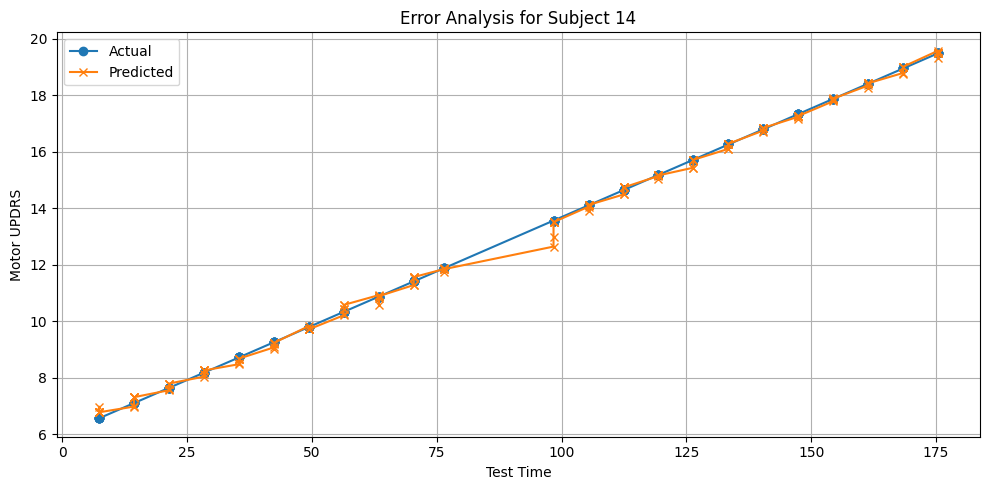


Model saved to: /content/drive/My Drive/parkinsons_model_final.pkl


In [26]:
# Main analysis pipeline
def main():
    # Load and split data
    data = load_data()
    train_subjects, test_subjects = train_test_split(
        data['subject#'].unique(),
        test_size=0.2,
        random_state=42
    )

    train_data = data[data['subject#'].isin(train_subjects)].copy()
    test_data = data[data['subject#'].isin(test_subjects)].copy()

    # Feature engineering
    train_data, train_stats = create_features(train_data)
    test_data, _ = create_features(test_data, train_stats)
    train_data = add_advanced_features(train_data) # Calling add_advanced_features to add new features
    test_data = add_advanced_features(test_data) # Calling add_advanced_features to add new features


    # Optimized feature set (removed PPE_trend)
    feature_cols = [
    'previous_motor_UPDRS', 'previous_total_UPDRS',
    'motor_diff', 'total_diff', 'motor_trend',
    'age', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE',
    'NHR_age', 'PPE_trend', 'motor_lag_1', 'motor_lag_2',
    'test_time_squared', 'motor_rolling_mean'
    ]

    # Prepare data
    X_train = train_data[feature_cols]
    y_train = train_data[['motor_UPDRS', 'total_UPDRS']]
    X_test = test_data[feature_cols]
    y_test = test_data[['motor_UPDRS', 'total_UPDRS']]

    # Temporal validation with expanding window
    tscv = TimeSeriesSplit(n_splits=5, test_size=20)
    # Enhanced optimization function
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 4),
            'gamma': trial.suggest_float('gamma', 0.8, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.7, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.8, 1),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8)
        }

        model = MultiOutputRegressor(XGBRegressor(**params, random_state=42))
        maes = []

        for train_idx, val_idx in tscv.split(X_train):
            # Maintain temporal order within patients
            X_tr = X_train.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_val = X_train.iloc[val_idx]
            y_val = y_train.iloc[val_idx]

            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            maes.append(mean_absolute_error(y_val, y_pred))

        return np.mean(maes)

    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30, timeout=3600)

    # Train final model
    best_params = study.best_params
    xgb_model = MultiOutputRegressor(
        XGBRegressor(**best_params, random_state=42)
    ).fit(X_train, y_train)

    # Compare with LightGBM
    lgbm_model = MultiOutputRegressor(
        LGBMRegressor(
            num_leaves=15,
            learning_rate=0.08,
            n_estimators=300,
            reg_alpha=0.7,
            reg_lambda=0.8,
            random_state=42
        )
    ).fit(X_train, y_train)
     # Evaluation
    def evaluate(model, X, y):
        y_pred = model.predict(X)
        return mean_absolute_error(y, y_pred)

    print("\nModel Comparison:")
    print("XGBoost Test MAE:", evaluate(xgb_model, X_test, y_test))
    print("LightGBM Test MAE:", evaluate(lgbm_model, X_test, y_test))

    # Error analysis visualization

    subject_id = 14
    subject_data = test_data[test_data['subject#'] == subject_id]
    subject_features = subject_data[feature_cols]
    subject_actual = subject_data['motor_UPDRS']
    subject_predicted = xgb_model.predict(subject_features)[:, 0]


    plt.figure(figsize=(10, 5))
    plt.plot(subject_data['test_time'], subject_actual, marker='o', label='Actual')
    plt.plot(subject_data['test_time'], subject_predicted, marker='x', label='Predicted')
    plt.title(f"Error Analysis for Subject {subject_id}")
    plt.xlabel("Test Time")
    plt.ylabel("Motor UPDRS")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Save best model

    save_path = '/content/drive/My Drive/parkinsons_model_final.pkl'
    joblib.dump({
        'model': xgb_model,
        'features': feature_cols,
        'stats': train_stats,
        'best_params': best_params
    }, save_path)
    print(f"\nModel saved to: {save_path}")
    return xgb_model, lgbm_model, X_test, y_test

if __name__ == "__main__":
    main()

In [27]:
import joblib

model_data = joblib.load('/content/drive/My Drive/parkinsons_model_final.pkl')

# Get model
model = model_data['model']

# ✅ Get features used during training
feature_names = model_data['features']
print("Features used for training:")
for feature in feature_names:
    print("-", feature)

# ✅ Optionally view hyperparameters
print("\nBest Hyperparameters:")
print(model_data['best_params'])


Features used for training:
- previous_motor_UPDRS
- previous_total_UPDRS
- motor_diff
- total_diff
- motor_trend
- age
- NHR
- HNR
- RPDE
- DFA
- PPE
- NHR_age
- PPE_trend
- motor_lag_1
- motor_lag_2
- test_time_squared
- motor_rolling_mean

Best Hyperparameters:
{'n_estimators': 281, 'learning_rate': 0.07070490781967245, 'max_depth': 4, 'gamma': 0.8363823267119973, 'reg_alpha': 0.8447284640494185, 'reg_lambda': 0.8438794439181958, 'subsample': 0.7679580481771984}


[I 2025-04-07 08:15:30,904] A new study created in memory with name: no-name-116a88ea-4003-4524-8fe2-31be4cd2a736
[I 2025-04-07 08:15:36,339] Trial 0 finished with value: 0.09565707370638847 and parameters: {'n_estimators': 234, 'learning_rate': 0.0860954212287937, 'max_depth': 4, 'gamma': 0.842268869947647, 'reg_alpha': 0.8527888912165347, 'reg_lambda': 0.8830420311792699, 'subsample': 0.6485834991267557}. Best is trial 0 with value: 0.09565707370638847.
[I 2025-04-07 08:15:38,435] Trial 1 finished with value: 0.126971797645092 and parameters: {'n_estimators': 241, 'learning_rate': 0.09729656812385339, 'max_depth': 3, 'gamma': 0.9268886975510843, 'reg_alpha': 0.9074233330930337, 'reg_lambda': 0.860391756498327, 'subsample': 0.6466005732920977}. Best is trial 0 with value: 0.09565707370638847.
[I 2025-04-07 08:15:40,684] Trial 2 finished with value: 0.1466546028852463 and parameters: {'n_estimators': 240, 'learning_rate': 0.0695570904402759, 'max_depth': 3, 'gamma': 0.8996616207816693,

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 17
[LightGBM] [Info] Start training from score 21.646407
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 17
[LightGBM] [Info] Start training from score 29.565597

Model Comparison:
XGBoost Test MAE: 0.11376680433750153
LightGBM Test MAE: 0.11164293851629695


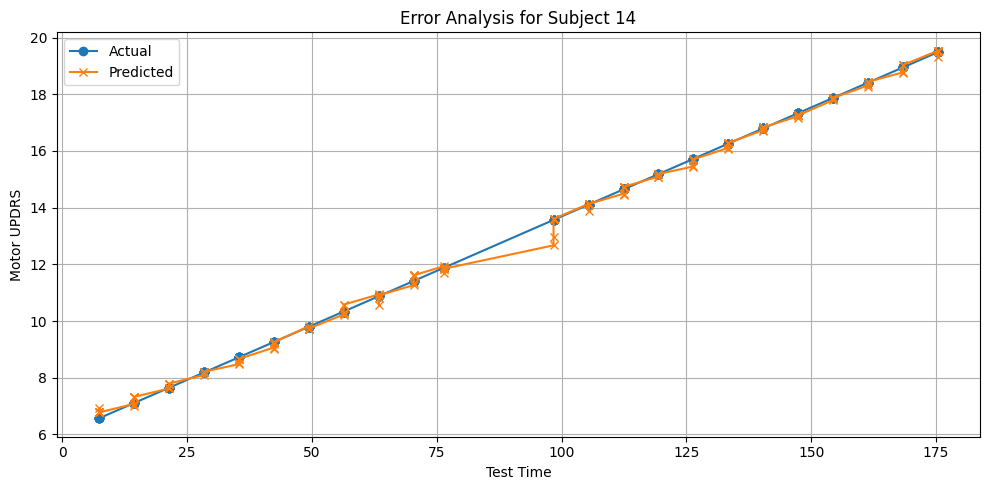


Model saved to: /content/drive/My Drive/parkinsons_model_final.pkl

Model Comparison:
🔹 XGBoost Test Scores:
{'MAE': 0.11376680433750153,
 'MSE': 0.06995438039302826,
 'R2': 0.999126136302948}

🔹 LightGBM Test Scores:
{'MAE': 0.11164293851629695,
 'MSE': 0.07527104739719616,
 'R2': 0.9990598259838529}


In [28]:
from sklearn.metrics import mean_squared_error, r2_score
from pprint import pprint
xgb_model, lgbm_model, X_test, y_test = main()

def evaluate(model, X, y):
    y_pred = model.predict(X)
    return {
        'MAE': mean_absolute_error(y, y_pred),
        'MSE': mean_squared_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

# Evaluate and print results
print("\nModel Comparison:")

xgb_metrics = evaluate(xgb_model, X_test, y_test)
print("🔹 XGBoost Test Scores:")
pprint(xgb_metrics)

lgbm_metrics = evaluate(lgbm_model, X_test, y_test)
print("\n🔹 LightGBM Test Scores:")
pprint(lgbm_metrics)
